In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Resize
from datasets.transform import Transform

from models import Encoder, Decoder, ConditionalDiffusion
from datasets.datasets import DiffusionDataset, DiffusionDatasetNoBG
from datasets.datasets import CondDiffusionDataset, CondDiffusionDatasetNoBG
from datasets.datasets import TargetCondDiffusionDataset

## Evaluate Encoder

In [2]:
remove_bg = False
data_path = 'data/'
batch_size = 16
rgb_data = np.load(os.path.join(data_path, 'rgb_128.npy'))
mask_data = np.load(os.path.join(data_path, 'segmap_128.npy'))
if remove_bg:
    dataset = DiffusionDatasetNoBG(rgb_data, mask_data)
else:
    dataset = DiffusionDataset(rgb_data)
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=1)

In [4]:
encoder_path = '1129_1701'
ckpt_dir = '/home/gun/ssd/disk/PreferenceDiffusion/tidying-line-diffusion'
latent_dim = 16

device = torch.device('cuda')
encoder = Encoder(output_dim=latent_dim).to(device)
decoder = Decoder(input_dim=latent_dim).to(device)

state_dict = torch.load(os.path.join(ckpt_dir, 'encoder_%s/checkpoint_best.pt' %encoder_path))
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])

[ models/temporal ] Channel dimensions: [(3, 32), (32, 64), (64, 128), (128, 256)]
[(3, 32), (32, 64), (64, 128), (128, 256)]
[ models/temporal ] Channel dimensions: [(16, 256), (256, 128), (128, 64), (64, 32)]


<All keys matched successfully>

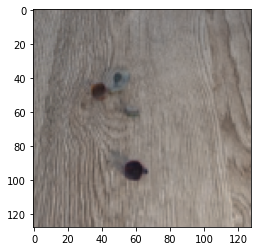

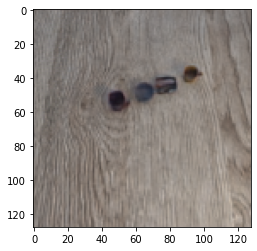

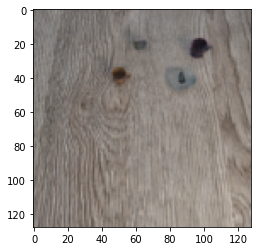

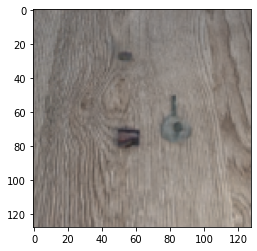

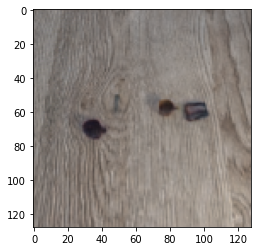

In [15]:
transform = Transform()
#resize = Resize((128, 128))

for batch in data_loader:
    x, mask = batch
    x = transform(x.permute((0, 3, 1, 2)))
    x = x.to(torch.float32).to(device)
    posterior, prior_loss = encoder(x)
    z = posterior.rsample()
    x_recon = decoder(z)
    img_recon = x_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = ((img_recon + 1) * 255 / 2).numpy().astype(np.uint8)
    for i in range(5):
        plt.imshow(img_recon[i])
        plt.show()
    break

## Evaluate Diffusion

In [2]:
remove_bg = False
data_path = 'data/'
batch_size = 4
rgb_data = np.load(os.path.join(data_path, 'rgb_128.npy'))
segmap_data = np.load(os.path.join(data_path, 'segmap_16.npy'))
if remove_bg:
    mask_data = np.load(os.path.join(data_path, 'segmap_128.npy'))
    dataset = CondDiffusionDatasetNoBG(rgb_data, segmap_data, mask_data)
else:
    dataset = CondDiffusionDataset(rgb_data, segmap_data)
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=1)

In [3]:
ldm_path = '1208_2347'
cond_type = 'mask'

latent_dim = 16
n_timesteps = 1000
ckpt_dir = '/home/gun/ssd/disk/PreferenceDiffusion/tidying-line-diffusion'

device = torch.device('cuda')
encoder = Encoder(output_dim=latent_dim).to(device)
decoder = Decoder(input_dim=latent_dim).to(device)
diffusion = ConditionalDiffusion(input_dim=latent_dim, cond_dim=latent_dim, n_timesteps=n_timesteps).to(device)

ldm_dir = [d for d in os.listdir(ckpt_dir) if d.startswith('diffusion_') and d.endswith(ldm_path)][0]
state_dict = torch.load(os.path.join(ckpt_dir, ldm_dir, 'checkpoint_best.pt'))
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])
diffusion.load_state_dict(state_dict['diffusion'])

[ models/temporal ] Channel dimensions: [(3, 32), (32, 64), (64, 128), (128, 256)]
[(3, 32), (32, 64), (64, 128), (128, 256)]
[ models/temporal ] Channel dimensions: [(16, 256), (256, 128), (128, 64), (64, 32)]
[ models/temporal ] Channel dimensions: [(16, 128), (128, 256), (256, 512), (512, 1024)]
[(16, 128), (128, 256), (256, 512), (512, 1024)]


<All keys matched successfully>

In [37]:
transform = Transform()
#resize = Resize((128, 128))

for batch in data_loader:
    x, masks, _ = batch
    x = transform(x.permute((0, 3, 1, 2)))
    x = x.to(torch.float32).to(device)
    masks = masks.to(device)
    posterior, _ = encoder(x)
    feature = posterior.mean

    cond = (masks != 0).to(torch.float32).view(-1, 1, 16, 16) * feature
    if cond_type=='point':
        cond = (masks!=0).to(torch.float32).view(-1, 1, 16, 16) * feature
    elif cond_type=='mask':
        cond = torch.zeros_like(feature)
        for m in range(1, 5):
            mask_m = (masks==m).to(torch.float32).view(-1, 1, 16, 16)
            count_m = mask_m.sum((2, 3))
            feature_m = mask_m * feature
            feature_m_mean = feature_m.sum((2, 3)) / count_m
            feature_m_mean = torch.where(count_m==0, torch.zeros_like(feature_m_mean), feature_m_mean)
            cond += mask_m * feature_m_mean.view(-1, 16, 1, 1)
    feature_recon = diffusion(cond)
    
    img = decoder(feature)
    img_recon = decoder(feature_recon)
    
    img = img.permute((0, 2, 3, 1)).detach().cpu()
    img = ((img + 1) * 255 / 2).numpy().astype(np.uint8)
    
    img_recon = img_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = ((img_recon + 1) * 255 / 2).numpy().astype(np.uint8)
    for i in range(4):
        plt.subplot(1, 2, 1)
        plt.imshow(img[i])
        plt.subplot(1, 2, 2)
        plt.imshow(img_recon[i])
        plt.show()
    break

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

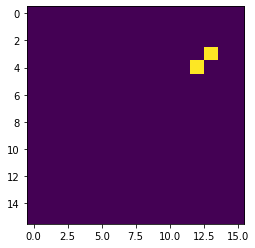

In [19]:
mask_npy = mask_m.detach().cpu().numpy()[1, 0]
plt.imshow(mask_npy)

In [18]:
masks[0].max()

tensor(3., device='cuda:0', dtype=torch.float64)

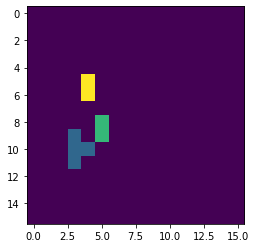

In [22]:
plt.imshow(masks.detach().cpu().numpy()[0])

In [8]:
def generate_new_masks(masks):
    new_masks = torch.zeros_like(masks)
    masks_npy = masks.detach().cpu().numpy()
    for m, mask_npy in enumerate(masks_npy):
        new_mask_npy = np.zeros_like(mask_npy)
        for i in range(1, 5):
            py, px = np.where(mask_npy==i)
            if len(py)==0:
                continue
            while True:
                bias_y, bias_x = np.random.choice([3, -3], 2)
                my, mx = py + bias_y, px + bias_x
                if not (my.max()>=16 or my.min()<0 or mx.max()>=16 or mx.min()<0):
                    break
            new_masks[m, my, mx] = i
    return new_masks

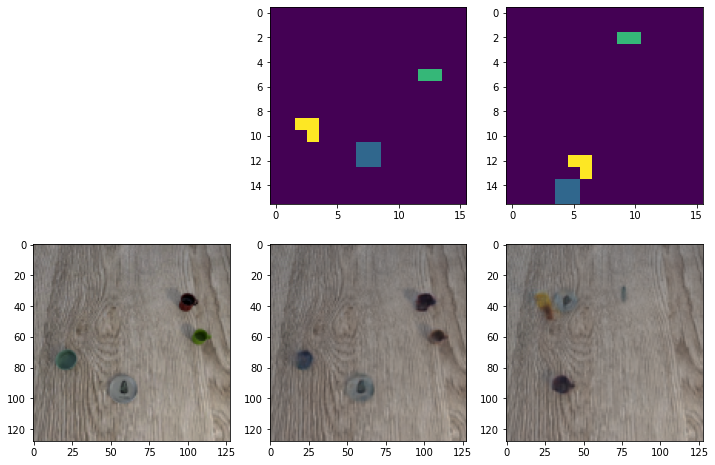

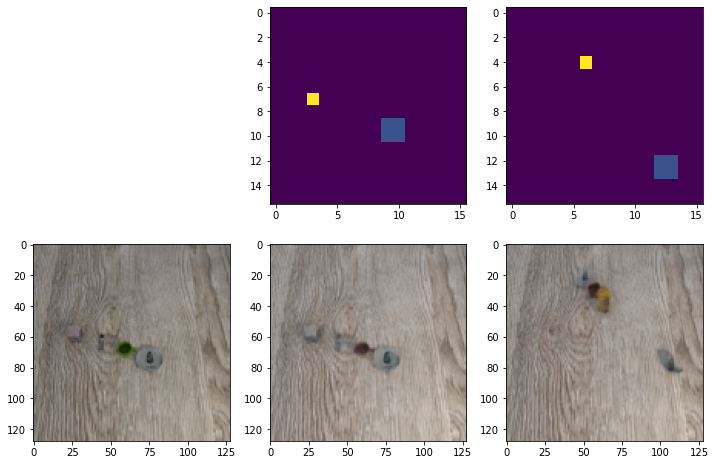

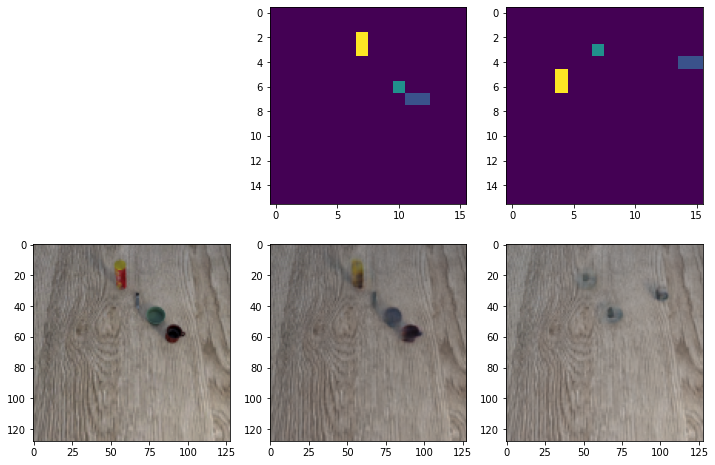

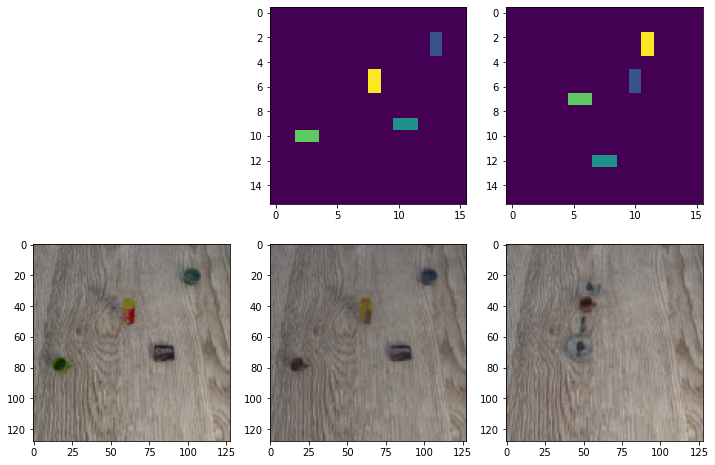

In [27]:
transform = Transform()
#resize = Resize((128, 128))

for batch in data_loader:
    x, masks, _ = batch
    x = transform(x.permute((0, 3, 1, 2)))
    x = x.to(torch.float32).to(device)
    new_masks = generate_new_masks(masks)
    masks = masks.to(device)
    new_masks = new_masks.to(device)
    posterior, _ = encoder(x)
    feature = posterior.mean

    if cond_type=='point':
        cond = (masks!=0).to(torch.float32).view(-1, 1, 16, 16) * feature
    elif cond_type=='mask':
        cond = torch.zeros_like(feature)
        for m in range(1, 5):
            mask_m = (masks==m).to(torch.float32).view(-1, 1, 16, 16)
            count_m = mask_m.sum((2, 3))
            feature_m = mask_m * feature
            feature_m_mean = feature_m.sum((2, 3)) / count_m
            feature_m_mean = torch.where(count_m==0, torch.zeros_like(feature_m_mean), feature_m_mean)
            cond += mask_m * feature_m_mean.view(-1, 16, 1, 1)
    feature_recon = diffusion(cond)
    
    if cond_type=='point':
        cond_prime = (new_masks!=0).to(torch.float32).view(-1, 1, 16, 16) * feature
    elif cond_type=='mask':
        cond_prime = torch.zeros_like(feature)
        for m in range(1, 5):
            new_mask_m = (new_masks==m).to(torch.float32).view(-1, 1, 16, 16)
            count_m = new_mask_m.sum((2, 3))
            feature_m = new_mask_m * feature
            feature_m_mean = feature_m.sum((2, 3)) / count_m
            feature_m_mean = torch.where(count_m==0, torch.zeros_like(feature_m_mean), feature_m_mean)
            cond_prime += new_mask_m * feature_m_mean.view(-1, 16, 1, 1)
    feature_recon_prime = diffusion(cond_prime)
    
    #img = decoder(feature)
    img_recon = decoder(feature_recon)
    img_recon_prime = decoder(feature_recon_prime)
    
    x_raw = ((x.detach().cpu().permute((0, 2, 3, 1)).numpy() + 1) * 255 / 2).astype(np.uint8)
    img_recon = img_recon.permute((0, 2, 3, 1)).detach().cpu()
    img_recon = ((img_recon + 1) * 255 / 2).numpy().astype(np.uint8)
    img_recon_prime = img_recon_prime.permute((0, 2, 3, 1)).detach().cpu()
    img_recon_prime = ((img_recon_prime + 1) * 255 / 2).numpy().astype(np.uint8)
    
    masks_npy = masks.detach().cpu().numpy()
    new_masks_npy = new_masks.detach().cpu().numpy()
    for i in range(4):
        f = plt.figure(figsize=(12, 8))
        #plt.subplot(2, 3, 1)
        #plt.imshow(x_raw[i])
        plt.subplot(2, 3, 2)
        plt.imshow(masks_npy[i])
        plt.subplot(2, 3, 3)
        plt.imshow(new_masks_npy[i])
        plt.subplot(2, 3, 4)
        plt.imshow(x_raw[i])
        plt.subplot(2, 3, 5)
        plt.imshow(img_recon[i])
        plt.subplot(2, 3, 6)
        plt.imshow(img_recon_prime[i])
        plt.show()
    break

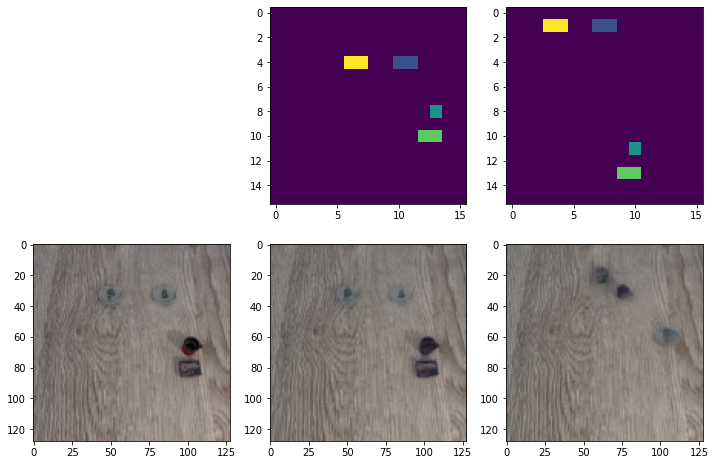

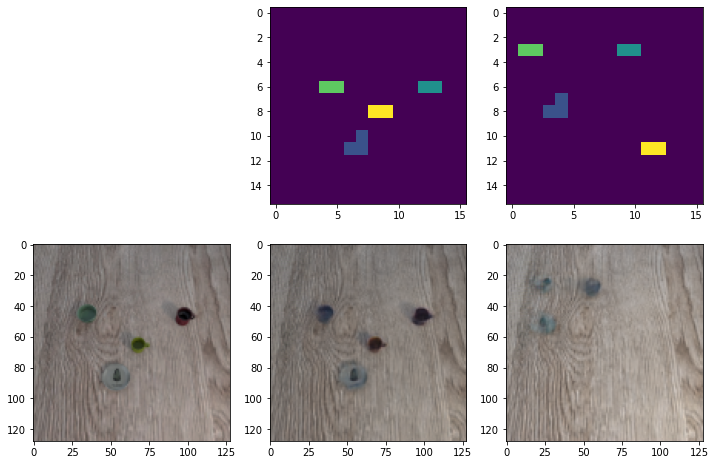

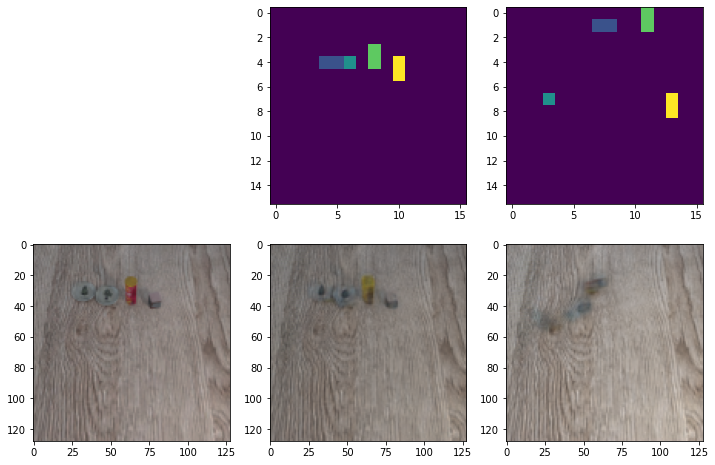

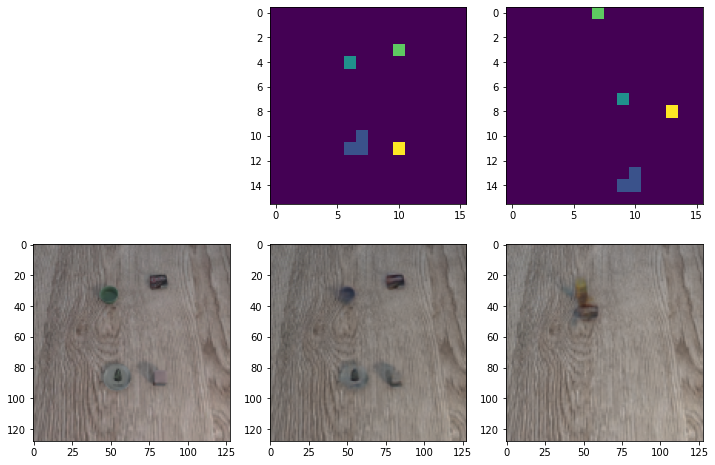

In [26]:
x_raw = ((x.detach().cpu().permute((0, 2, 3, 1)).numpy() + 1) * 255 / 2).astype(np.uint8)
masks_npy = masks.detach().cpu().numpy()
new_masks_npy = new_masks.detach().cpu().numpy()
for i in range(4):
    f = plt.figure(figsize=(12, 8))
    #plt.subplot(2, 3, 1)
    #plt.imshow(x_raw[i])
    plt.subplot(2, 3, 2)
    plt.imshow(masks_npy[i])
    plt.subplot(2, 3, 3)
    plt.imshow(new_masks_npy[i])
    plt.subplot(2, 3, 4)
    plt.imshow(x_raw[i])
    plt.subplot(2, 3, 5)
    plt.imshow(img_recon[i])
    plt.subplot(2, 3, 6)
    plt.imshow(img_recon_prime[i])
    plt.show()

(4, 16, 16)

## Target Condition Diffusion

In [22]:
data_path = 'data/'
batch_size = 16
rgb_data = np.load(os.path.join(data_path, 'rgb_128.npy'))
segmap_data = np.load(os.path.join(data_path, 'segmap_16.npy'))
mask_data = np.load(os.path.join(data_path, 'segmap_128.npy'))
dataset = TargetCondDiffusionDataset(rgb_data, segmap_data, num_duplication=5)

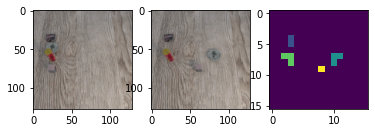

In [30]:
r_s, r_t, s_t = dataset.__getitem__(52)
plt.subplot(1, 3, 1)
plt.imshow(r_s)
plt.subplot(1, 3, 2)
plt.imshow(r_t)
plt.subplot(1, 3, 3)
plt.imshow(s_t)
plt.show()